In [1]:
import json
#from google.colab import drive

# Get the notebook's filename (usually matches the GitHub repo name)
!ls *.ipynb
notebook_name = "NLPProject.ipynb"  # ← Replace with your filename

# Load and fix the notebook
with open(notebook_name, 'r') as f:
    nb = json.load(f)

# Option A: Remove widgets metadata completely (recommended)
if 'metadata' in nb and 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Option B: Or add the missing state key
# if 'metadata' in nb and 'widgets' in nb['metadata']:
#     nb['metadata']['widgets']['state'] = {}

# Save the fixed version
with open(notebook_name, 'w') as f:
    json.dump(nb, f)

print("Notebook metadata fixed! You can now commit to GitHub.")

NLPProject.ipynb  NLPProject2.ipynb
Notebook metadata fixed! You can now commit to GitHub.


In [2]:
from pprint import pprint
from operator import itemgetter
import nltk
from nltk.corpus import framenet as fn
from nltk.corpus.reader.framenet import PrettyList
nltk.download('framenet_v17')

[nltk_data] Downloading package framenet_v17 to
[nltk_data]     /Users/kierstenwener/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


True

In [3]:
frame_element_counts = {}
#for each frame, loops through all frame elements
for frame in fn.frames():
    frame_name = frame.name

    for fe_name, fe in frame.FE.items():

        sample_sentences = frame.lexUnit
        num_sentences = len(sample_sentences)

        # Store the count of sentences for each frame element
        if fe_name in frame_element_counts:
            frame_element_counts[fe_name] += num_sentences  # Add the new count to the existing one
        else:
            frame_element_counts[fe_name] = num_sentences

sorted_frame_elements = sorted(frame_element_counts.items(), key=lambda x: x[1], reverse=True)
for fe_name, count in sorted_frame_elements[:10]:
    print(f"Frame Element: {fe_name}, Sample Sentences: {count}")

Frame Element: Time, Sample Sentences: 8170
Frame Element: Manner, Sample Sentences: 7612
Frame Element: Place, Sample Sentences: 7037
Frame Element: Degree, Sample Sentences: 7012
Frame Element: Means, Sample Sentences: 5045
Frame Element: Explanation, Sample Sentences: 4539
Frame Element: Depictive, Sample Sentences: 4091
Frame Element: Purpose, Sample Sentences: 4091
Frame Element: Circumstances, Sample Sentences: 3219
Frame Element: Duration, Sample Sentences: 3120


In [4]:
frames_with_time_ex = {}
for f in fn.frames():
    for x in f.FE:
        if x == "Time":
            frames_with_time_ex[f.name] = f

In [5]:
def align_labels_with_tokens(text, char_labels, offsets):
    token_labels = []
    for (token_start, token_end) in offsets:
        # For special tokens like [CLS] and [SEP], offset is usually (0,0)
        if token_start == token_end:
            token_labels.append("O")
        else:
            # If any character in the token is marked as Time,
            # decide on a label for the entire token.
            token_tag = "O"
            for pos in range(token_start, token_end):
                if pos < len(char_labels) and char_labels[pos] != "O":
                    token_tag = char_labels[pos]
                    break
            token_labels.append(token_tag)
    return token_labels

In [6]:
import torch
from nltk.corpus import framenet as fn
from transformers import BertTokenizerFast

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Map BIO tags to IDs
label2id = {"O": 0, "B-Time": 1, "I-Time": 2}
input_ids_list = []
attention_masks_list = []
labels_list = []

# Find frames that include "Time" as a frame element

for name, frame in frames_with_time_ex.items():
    # Print the frame name for reference
    for lu in frame.lexUnit.values():
        #print(f"\nLexical Unit: {lu['name']}")
        lu_data = fn.lu(lu['ID'])
        for ex in lu_data['exemplars']:
            text = ex['text']
            char_labels = ["O"] * len(text)
            has_time_fe = False

            for fe in ex['FE']:
                for i in fe:
                    if i[2] == "Time":
                        start, end = i[0], i[1]
                        if start < end:
                            char_labels[start] = "B-Time"
                            for i in range(start+1, end):
                                char_labels[i] = "I-Time"
                            has_time_fe = True
            if not has_time_fe:
                continue


            # Tokenize
            tokenized = tokenizer(text, return_offsets_mapping=True, truncation=True, padding="max_length", max_length=128)
            input_ids = tokenized["input_ids"]
            attention_mask = tokenized["attention_mask"]
            offsets = tokenized["offset_mapping"]

            # Map character-level labels to token-level labels
            token_labels = align_labels_with_tokens(text, char_labels, offsets)
            label2id_binary = {"O": 0, "B-Time": 1, "I-Time": 1}  # Map both B-Time and I-Time to 1
            # Pad remaining labels with -100 where attention mask is 0 (i.e., padding tokens)


            label_ids = [label2id_binary.get(lab, 0) for lab in token_labels]
            label_ids = [
                label if mask == 1 else -100 
                for label, mask in zip(label_ids, attention_mask)
            ]
            # Store tensors
            input_ids_list.append(torch.tensor(input_ids))
            attention_masks_list.append(torch.tensor(attention_mask))
            labels_list.append(torch.tensor(label_ids))

# Final dataset tensors
input_ids_tensor = torch.stack(input_ids_list)
attention_masks_tensor = torch.stack(attention_masks_list)
labels_tensor = torch.stack(labels_list)

print("Tensor shapes:")
print("Input IDs:", input_ids_tensor.shape)
print("Attention Masks:", attention_masks_tensor.shape)
print("Labels:", labels_tensor.shape)

/Users/kierstenwener/Desktop/NLPProject/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensor shapes:
Input IDs: torch.Size([9013, 128])
Attention Masks: torch.Size([9013, 128])
Labels: torch.Size([9013, 128])


In [7]:
indices = (labels_tensor == 1).nonzero(as_tuple=False)
sample_idx, token_idx = indices[0].tolist()
token_id = input_ids_tensor[sample_idx][token_idx]
token = tokenizer.convert_ids_to_tokens([token_id])[0]
print(f"Token: {token}")

Token: when


In [8]:
tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor[sample_idx])
print("Tokens:", tokens)

Tokens: ['[CLS]', 'she', 'had', 'seen', 'no', 'reason', 'to', 'abandon', 'it', 'when', 'she', 'came', 'to', 'med', '##ew', '##ich', 'two', 'years', 'ago', ',', 'even', 'though', 'she', 'might', 'now', 'have', 'been', 'able', 'to', 'afford', 'a', 'car', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [9]:
labels = labels_tensor[sample_idx]
for tok, label in zip(tokens, labels):
    print(f"{tok:15} -> {label.item()}")

[CLS]           -> 0
she             -> 0
had             -> 0
seen            -> 0
no              -> 0
reason          -> 0
to              -> 0
abandon         -> 0
it              -> 0
when            -> 1
she             -> 1
came            -> 1
to              -> 1
med             -> 1
##ew            -> 1
##ich           -> 1
two             -> 1
years           -> 1
ago             -> 1
,               -> 0
even            -> 0
though          -> 0
she             -> 0
might           -> 0
now             -> 0
have            -> 0
been            -> 0
able            -> 0
to              -> 0
afford          -> 0
a               -> 0
car             -> 0
.               -> 0
[SEP]           -> 0
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -10

In [10]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(input_ids_tensor, attention_masks_tensor, labels_tensor)


In [11]:
from torch.utils.data import DataLoader, RandomSampler, SubsetRandomSampler
from torch.utils.data import random_split
# Parameters
batch_size = 5
validation_split = 0.5

train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Shuffle the data
    batch_size=batch_size
)

# Create DataLoader for validation (without shuffling)
val_dataloader = DataLoader(
    val_dataset,
    sampler=SubsetRandomSampler(range(len(val_dataset))),  # Don't shuffle validation data
    batch_size=batch_size
)

In [12]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

class FrameElementClassifier(nn.Module):
    def __init__(self, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        #self.query_encoder = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.token_projection = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
        self.dropout = nn.Dropout(0.1)

    #def forward(self, input_ids, attention_mask, role_ids, role_mask):
    def forward(self, input_ids, attention_mask):
        # Encode sentence
        sentence_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = sentence_outputs.last_hidden_state  # shape: (B, T, H)
        """
        # Encode role label (like "Time" or "Manner")
        role_output = self.bert(input_ids=role_ids, attention_mask=role_mask)
        role_embedding = role_output.last_hidden_state[:, 0, :]  # [CLS] token: shape (B, H)
        role_embedding = self.query_encoder(role_embedding)  # shape: (B, H)
"""
        # Project sentence tokens
        token_embeddings = self.token_projection(token_embeddings)  # shape: (B, T, H)
        logits = self.classifier(token_embeddings)
        # Compute dot product between role embedding and each token
        #role_embedding = role_embedding.unsqueeze(2)  # (B, H, 1)
        #scores = torch.bmm(token_embeddings, role_embedding).squeeze(-1)  # shape: (B, T)

        # Optionally apply attention mask
        #scores = scores.masked_fill(attention_mask == 0, -1e9)
        #probs = torch.softmax(logits, dim=-1)
        #logits = self.classifier(token_embeddings)
        return logits  # Apply softmax for inference or use with CrossEntropyLoss

run for a few more epochs

In [13]:
num_epochs = 15
accuracies = []
num_batches = 15
model = FrameElementClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor([0.4, 0.6]).to(device)  # Make Time more important
loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        print(i)
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer.zero_grad()
        
        probs = model(input_ids, attention_mask)
        loss = loss_fn(probs.view(-1, 2), target_index.view(-1))
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


evaluation stuff

In [14]:
from sklearn.metrics import confusion_matrix

model.eval()
true_time_total = 0
true_time_correct = 0

# For confusion matrix
all_true_binary = []
all_pred_binary = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        probs = model(input_ids, attention_mask)
        probs_softmax = torch.softmax(probs, dim=-1)
        predicted_tokens = torch.argmax(probs_softmax, dim=-1)

        # Binary labels: 1 for "Time", 0 for everything else
        is_time_token = (target_index == 1)
        predicted_time_token = (predicted_tokens == 1)

        correct_time_preds = predicted_time_token & is_time_token

        true_time_total += is_time_token.sum().item()
        true_time_correct += correct_time_preds.sum().item()

        # Flatten and convert to binary 0/1
        all_true_binary.extend(is_time_token.view(-1).cpu().numpy())
        all_pred_binary.extend(predicted_time_token.view(-1).cpu().numpy())

if true_time_total > 0:
    time_recall = true_time_correct / true_time_total
    print(f"Time FE Recall: {time_recall:.4f} ({true_time_correct}/{true_time_total})")
else:
    print("No Time FEs found in validation set.")

# Compute confusion matrix
cm = confusion_matrix(all_true_binary, all_pred_binary)
print("Confusion Matrix (for 'Time' class prediction):")
print(cm)


Time FE Recall: 0.6895 (211/306)
Confusion Matrix (for 'Time' class prediction):
[[8873  421]
 [  95  211]]


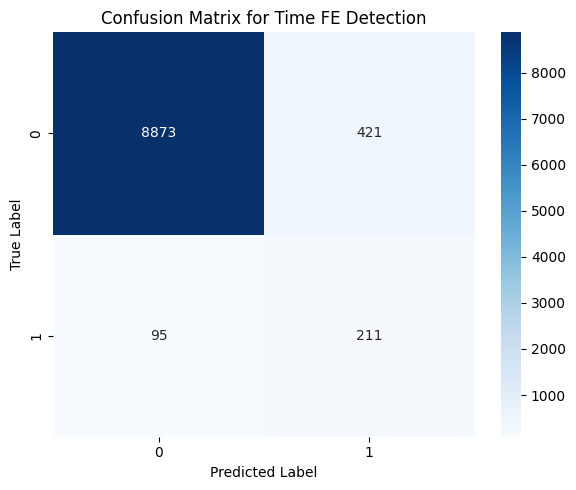

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()

In [22]:
model.eval()
true_time_total = 0
true_time_correct = 0

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        probs = model(input_ids, attention_mask)
        probs_softmax = torch.softmax(probs, dim=-1)
        predicted_tokens = torch.argmax(probs_softmax, dim=-1)

        # Only count tokens that were labeled as "Time" (class 1) in the ground truth
        is_time_token = (target_index == 1)
        correct_time_preds = (predicted_tokens == 1) & is_time_token

        true_time_total += is_time_token.sum().item()
        true_time_correct += correct_time_preds.sum().item()

if true_time_total > 0:
    time_recall = true_time_correct / true_time_total
    print(f"Time FE Recall: {time_recall:.4f} ({true_time_correct}/{true_time_total})")
else:
    print("No Time FEs found in validation set.")


Time FE Recall: 0.8051 (219/272)


In [16]:

num_printed = 0
max_to_print = 5  # Adjust how many examples you want to print

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches or num_printed >= max_to_print:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        probs = model(input_ids, attention_mask)
        probs_softmax = torch.softmax(probs, dim=-1)
        predicted_tokens = torch.argmax(probs_softmax, dim=-1)

        # Loop through each sentence in the batch
        for b in range(input_ids.size(0)):
            mask = target_index[b] != -100
            true_labels = target_index[b][mask].cpu().numpy()
            pred_labels = predicted_tokens[b][mask].cpu().numpy()

            print(f"\n--- Example {num_printed + 1} ---")
            print("Predicted :", pred_labels)
            print("True      :", true_labels)

            num_printed += 1
            if num_printed >= max_to_print:
                break



--- Example 1 ---
Predicted : [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True      : [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

--- Example 2 ---
Predicted : [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True      : [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]

--- Example 3 ---
Predicted : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
True      : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]

--- Example 4 ---
Predicted : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0]
True      : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 0 0]

--- Example 5 ---
Predicted : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0]
True      : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0]


In [21]:
model.eval()
num_examples_to_print = 5  # or however many you want
examples_printed = 0

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        probs = model(input_ids, attention_mask)
        preds = torch.argmax(torch.softmax(probs, dim=-1), dim=-1)

        for j in range(input_ids.size(0)):
            if examples_printed >= num_examples_to_print:
                break

            input_id = input_ids[j]
            attention = attention_mask[j]
            pred = preds[j]
            label = target_index[j]

            # Only consider real (non-padding) tokens
            mask = (attention == 1) & (label != -100)
            input_id = input_id[mask]
            pred = pred[mask]
            label = label[mask]

            tokens = tokenizer.convert_ids_to_tokens(input_id)
            sentence = tokenizer.convert_tokens_to_string(tokens)

            print(f"\n🔹 Sentence {examples_printed + 1}:")
            print(f"   Text: {sentence}")
            print(f"   Tokens: {tokens}")
            print(f"   True Labels:     {label.tolist()}")
            print(f"   Predicted Labels:{pred.tolist()}")

            # Optional: highlight mismatches
            print("   Comparison:")
            for tok, gold, guess in zip(tokens, label.tolist(), pred.tolist()):
                status = "✅" if gold == guess else "❌"
                print(f"     {tok:15} | True: {gold} | Pred: {guess} {status}")

            examples_printed += 1



🔹 Sentence 1:
   Text: [CLS] gloucestershire police confirmed today that they have questioned the pair. [SEP]
   Tokens: ['[CLS]', 'gloucestershire', 'police', 'confirmed', 'today', 'that', 'they', 'have', 'questioned', 'the', 'pair', '.', '[SEP]']
   True Labels:     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
   Predicted Labels:[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
   Comparison:
     [CLS]           | True: 0 | Pred: 0 ✅
     gloucestershire | True: 0 | Pred: 0 ✅
     police          | True: 0 | Pred: 0 ✅
     confirmed       | True: 0 | Pred: 0 ✅
     today           | True: 1 | Pred: 1 ✅
     that            | True: 0 | Pred: 0 ✅
     they            | True: 0 | Pred: 0 ✅
     have            | True: 0 | Pred: 0 ✅
     questioned      | True: 0 | Pred: 0 ✅
     the             | True: 0 | Pred: 0 ✅
     pair            | True: 0 | Pred: 0 ✅
     .               | True: 0 | Pred: 0 ✅
     [SEP]           | True: 0 | Pred: 0 ✅

🔹 Sentence 2:
   Text: [CLS] two swedish engineers kidn

KeyboardInterrupt: 

In [23]:
import torch
from tqdm import tqdm

def extract_binary_spans(label_seq):
    spans = []
    start = None
    for i, val in enumerate(label_seq):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            spans.append((start, i - 1))
            start = None
    if start is not None:
        spans.append((start, len(label_seq) - 1))
    return spans

def evaluate_binary_predictions(true_labels_list, pred_labels_list):
    strict_match = 0
    partial_match = 0
    total_spans = 0

    for true_seq, pred_seq in zip(true_labels_list, pred_labels_list):
        true_spans = extract_binary_spans(true_seq)
        pred_spans = extract_binary_spans(pred_seq)
        total_spans += len(true_spans)

        for t_start, t_end in true_spans:
            t_range = set(range(t_start, t_end + 1))
            match_found = False
            for p_start, p_end in pred_spans:
                p_range = set(range(p_start, p_end + 1))
                if t_range == p_range:
                    strict_match += 1
                    match_found = True
                    break
                elif t_range & p_range:
                    match_found = True
            if match_found:
                partial_match += 1

    return {
        "Total Time Elements": total_spans,
        "Strict Matches": strict_match,
        "Partial Matches": partial_match,
        "Strict Accuracy": strict_match / total_spans if total_spans > 0 else 0,
        "Partial Accuracy": partial_match / total_spans if total_spans > 0 else 0
    }

# ⬇️ EVALUATION CODE
def evaluate_model(model, val_dataloader, device):
    model.eval()
    true_labels_all = []
    pred_labels_all = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=-1)  # shape: (B, T)

            for label_seq, pred_seq, mask in zip(labels, predictions, attention_mask):
                # Remove padding (-100) and apply attention mask
                true_seq = [label.item() for label, m in zip(label_seq, mask) if m == 1 and label != -100]
                pred_seq = [pred.item() for pred, m in zip(pred_seq, mask) if m == 1]

                true_labels_all.append(true_seq)
                pred_labels_all.append(pred_seq[:len(true_seq)])  # Match lengths just in case

    return evaluate_binary_predictions(true_labels_all, pred_labels_all)


In [24]:
results = evaluate_model(model, val_dataloader, device)
print("📊 Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 902/902 [03:14<00:00,  4.63it/s]

📊 Evaluation Results:
Total Time Elements: 4612
Strict Matches: 3393
Partial Matches: 4221
Strict Accuracy: 0.736
Partial Accuracy: 0.915
